In [1]:
# HPC
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

# For surfvel data in tif files
import rasterio
from rasterio.transform import from_origin

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
modelPath = '/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/'
dataPath = '/scratch2/shreyas/GrIS_paleo_data/'

ds_bm5_orig = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms_orig.nc")

ds_surfvel_model_40km = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp/grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp0007.nc')
ds_surfvel_model_40km["vs"] = ds_surfvel_model_40km['vh_s'].copy()
ds_surfvel_model_40km["vx"] = ds_surfvel_model_40km['vx_s_g'].copy()
ds_surfvel_model_40km["vy"] = ds_surfvel_model_40km['vy_s_g'].copy()
ds_surfvel_model_40km["vs_uncert"] = ds_surfvel_model_40km["vs"].copy()*0.0 + 10.0
ds_surfvel_model_40km["vx_uncert"] = ds_surfvel_model_40km["vx"].copy()*0.0 + 10.0
ds_surfvel_model_40km["vy_uncert"] = ds_surfvel_model_40km["vy"].copy()*0.0 + 10.0
ds_surfvel_model_40km.to_netcdf('/scratch2/shreyas/GrIS_paleo_data/fake_surfvel_data_40kms.nc', mode='w')

In [3]:
xModel10 = np.arange(-72.,97.,1.0)*10
yModel10 = np.arange(-345.,-56.,1.0)*10
xModel16 = np.arange(-72.,97.,1.6)*10
yModel16 = np.arange(-345.,-56.,1.6)*10
xModel40 = np.arange(-72.,97.,4.0)*10
yModel40 = np.arange(-345.,-56.,4.0)*10

In [4]:
def read_field_from_tif(file_path):

    # Open the file
    with rasterio.open(file_path) as dataset:

        # # Print metadata information about the GeoTIFF file
        # print(dataset.meta)
        
        # Read the data from the first band (if the image has multiple bands)
        field = dataset.read(1)

        # SSG: Invert y-axis to match Ralf's surfvel data convention
        field = field[::-1]
        
        # # Accessing additional information
        # print(f"Width: {dataset.width}")
        # print(f"Height: {dataset.height}")
        # print(f"Number of Bands: {dataset.count}")

        return field

vs_data = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vs_v1.tif")
vx_data = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vx_v1.tif")
vx_uncert_data = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_ex_v1.tif")
vy_data = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vy_v1.tif")
vy_uncert_data = read_field_from_tif("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_ey_v1.tif")

ds = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/greenland_vel_mosaic250_vs_v1.nc")
xs = ds["x"].data / 1000.0
ys = ds["y"].data / 1000.0

In [5]:
def frac_area(x, y, xx, yy):
    """
    Compute the fraction of the area of the small rectangle (xx, yy)
    within the large rectangle (x, y).

    Parameters:
        x, y:   Length-2 arrays for the large rectangle [x1, x2], [y1, y2]
        xx, yy: Length-2 arrays for the small rectangle

    Returns:
        Fraction of area of (xx, yy) within (x, y)
    """

    x = sorted(x)
    y = sorted(y)
    xx = sorted(xx)
    yy = sorted(yy)

    dx_inv = 1.0 / (x[1] - x[0])
    dy_inv = 1.0 / (y[1] - y[0])

    # normalized x-bounds and y-bounds of the small rectangle in the large rectangle's coordinate space
    xxm = (np.array(xx) - x[0]) * dx_inv
    yym = (np.array(yy) - y[0]) * dy_inv

    if (xx[1] - xx[0] > x[1] - x[0]) or (yy[1] - yy[0] > y[1] - y[0]):
        raise ValueError("Small rectangle larger than large rectangle!")

    # Case 1: Fully inside
    if 0 <= xxm[0] and xxm[1] <= 1 and 0 <= yym[0] and yym[1] <= 1:
        return 1.0

    # Partial overlaps along one edge
    if 0 <= xxm[0] and xxm[1] <= 1:
        if yym[0] < 0 < yym[1]:
            return yym[1] / (yym[1] - yym[0])
        elif yym[0] < 1 < yym[1]:
            return (1 - yym[0]) / (yym[1] - yym[0])
        else:
            return 0.0

    if 0 <= yym[0] and yym[1] <= 1:
        if xxm[0] < 0 < xxm[1]:
            return xxm[1] / (xxm[1] - xxm[0])
        elif xxm[0] < 1 < xxm[1]:
            return (1 - xxm[0]) / (xxm[1] - xxm[0])
        else:
            return 0.0

    # Partial overlaps at corners
    denom = (xxm[1] - xxm[0]) * (yym[1] - yym[0])
    if denom == 0:
        return 0.0

    if xxm[0] < 0 < xxm[1] and yym[0] < 0 < yym[1]:
        return xxm[1] * yym[1] / denom
    if xxm[0] < 1 < xxm[1] and yym[0] < 0 < yym[1]:
        return (1 - xxm[0]) * yym[1] / denom
    if xxm[0] < 0 < xxm[1] and yym[0] < 1 < yym[1]:
        return xxm[1] * (1 - yym[0]) / denom
    if xxm[0] < 1 < xxm[1] and yym[0] < 1 < yym[1]:
        return (1 - xxm[0]) * (1 - yym[0]) / denom

    return 0.0

def downsample_field(xs, ys, field_data, x_sico, y_sico, dx_ms, dx):
    """
    Downsample a 2D field using area-weighted averaging from fine to coarse grid.

    Parameters:
        xs, ys         - 1D fine grid coordinates (x_ms, y_ms)
        field_data     - 2D array on fine grid, shape (len(ys), len(xs))
        x_sico, y_sico - 1D coarse grid coordinates
        dx_ms          - fine grid spacing (same for x and y)
        dx             - coarse grid spacing (same for x and y)

    Returns:
        field_interp   - 2D array on coarse grid (len(y_sico), len(x_sico))
    """

    field_interp = np.zeros((len(y_sico), len(x_sico)))
    sum_weight = np.zeros_like(field_interp)
    sum_weight_max = (dx / dx_ms) ** 2

    for i, x in enumerate(x_sico):

        for j, y in enumerate(y_sico):

            # Handle points outside domain
            if x < xs[0] or x > xs[-1] or y < ys[0] or y > ys[-1]:
                continue

            # Define bounding box around current coarse cell
            x1 = x - 0.5 * (dx + dx_ms)
            x2 = x + 0.5 * (dx + dx_ms)
            y1 = y - 0.5 * (dx + dx_ms)
            y2 = y + 0.5 * (dx + dx_ms)

            # Convert bounding box to index range in BedMachine grid
            ii1 = int(np.floor((x1 - xs[0]) / dx_ms))
            ii2 = int(np.ceil((x2 - xs[0]) / dx_ms))
            jj1 = int(np.floor((y1 - ys[0]) / dx_ms))
            jj2 = int(np.ceil((y2 - ys[0]) / dx_ms))

            # Loop over overlapping fine grid cells
            for ii in range(ii1, ii2):
                for jj in range(jj1, jj2):
                    if 0 <= ii < len(xs) and 0 <= jj < len(ys):
                        val = field_data[jj, ii]
                        if not np.isnan(val):
                            weight = frac_area(
                                [x - 0.5 * dx, x + 0.5 * dx],
                                [y - 0.5 * dx, y + 0.5 * dx],
                                [xs[ii] - 0.5 * dx_ms, xs[ii] + 0.5 * dx_ms],
                                [ys[jj] - 0.5 * dx_ms, ys[jj] + 0.5 * dx_ms],
                            )
                            sum_weight[j, i] += weight
                            field_interp[j, i] += weight * val

            # Normalize sums by total weight to get downsampled values
            if sum_weight[j, i] > 0.5 * sum_weight_max:
                field_interp[j, i] /= sum_weight[j, i]
            else:
                field_interp[j, i] = 0.0

    return field_interp

vx_data[vx_data < -1.5e9] = np.nan
vy_data[vy_data < -1.5e9] = np.nan
vs_data[vs_data < -1.5e9] = np.nan
vx_uncert_data[vx_uncert_data < -1.5e9] = np.nan
vy_uncert_data[vy_uncert_data < -1.5e9] = np.nan

vs_data_interp = downsample_field(xs=xs, ys=ys, field_data=vs_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)
vx_data_interp = downsample_field(xs=xs, ys=ys, field_data=vx_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)
vy_data_interp = downsample_field(xs=xs, ys=ys, field_data=vy_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)
vx_uncert_data_interp = downsample_field(xs=xs, ys=ys, field_data=vx_uncert_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)
vy_uncert_data_interp = downsample_field(xs=xs, ys=ys, field_data=vy_uncert_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)

In [6]:
np.nansum(vx_uncert_data > np.abs(vx_data)) / (vx_data.shape[0]*vx_data.shape[1]) * 100

5.2357556618353955

In [7]:
np.nanmax(vx_uncert_data/np.abs(vx_data)), \
np.nanmax(vx_uncert_data/np.abs(vx_data) * (np.abs(vx_data) > 10.0)), \
np.nanmax(vx_uncert_data/np.abs(vx_data) * (np.abs(vx_data) > 100.0))

(2149045.2, 14.549711, 1.402455)

In [8]:
np.nansum(vy_uncert_data > np.abs(vy_data)) / (vy_data.shape[0]*vy_data.shape[1]) * 100

8.345032735813467

In [9]:
np.nanmax(vy_uncert_data/np.abs(vy_data)), \
np.nanmax(vy_uncert_data/np.abs(vy_data) * (np.abs(vy_data) > 10.0)), \
np.nanmax(vy_uncert_data/np.abs(vy_data) * (np.abs(vy_data) > 100.0))

(38456024.0, 14.865811, 1.9527869)

In [10]:
# OLD WAY
vx_uncert_data_interp_old = vx_uncert_data_interp.copy()
vy_uncert_data_interp_old = vy_uncert_data_interp.copy()
vx_uncert_data_interp_old[vx_uncert_data_interp_old == 0.0] = -2.e9
vy_uncert_data_interp_old[vy_uncert_data_interp_old == 0.0] = -2.e9

# NEW WAY
vx_uncert_data_interp[vx_uncert_data_interp == 0.0] = 1.0
vy_uncert_data_interp[vy_uncert_data_interp == 0.0] = 1.0

In [11]:
ds_surfvel_data_40km_orig = xr.open_dataset(dataPath + 'surfvel_data_40kms_orig.nc')
vs_orig = ds_surfvel_data_40km_orig["vs"].data
vs_data_interp_calc = np.sqrt(vx_data_interp**2 + vy_data_interp**2)
np.nansum(np.abs((vs_orig-vs_data_interp)/vs_orig))/np.sum(vs_orig > 0), np.nansum(np.abs((vs_orig-vs_data_interp_calc)/vs_orig))/np.sum(vs_orig > 0)

/tmp/ipykernel_3237276/1181234617.py:4: RuntimeWarning: invalid value encountered in divide
  np.nansum(np.abs((vs_orig-vs_data_interp)/vs_orig))/np.sum(vs_orig > 0), np.nansum(np.abs((vs_orig-vs_data_interp_calc)/vs_orig))/np.sum(vs_orig > 0)


(2.119570653391888e-08, 0.158914788798674)

In [12]:
da_vs_data_orig = xr.DataArray(
        data = vs_orig,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vs OG in ma^(-1)"),
    )

da_vs_data_interp = xr.DataArray(
        data = vs_data_interp,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vs in ma^(-1)"),
    )

da_vx_data_interp = xr.DataArray(
        data = vx_data_interp,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vx in ma^(-1)"),
    )

da_vy_data_interp = xr.DataArray(
        data = vy_data_interp,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vy in ma^(-1)"),
    )

da_vx_uncert_data_interp = xr.DataArray(
        data = vx_uncert_data_interp,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vx_uncert in ma^(-1)"),
    )

da_vy_uncert_data_interp = xr.DataArray(
        data = vy_uncert_data_interp,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vy_uncert in ma^(-1)"),
    )

da_vx_uncert_data_interp_old = xr.DataArray(
        data = vx_uncert_data_interp_old,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vx_uncert old way in ma^(-1)"),
    )

da_vy_uncert_data_interp_old = xr.DataArray(
        data = vy_uncert_data_interp_old,
        dims = ["y", "x"],
        coords = dict(
            y = yModel40,
            x = xModel40,
        ),  
        attrs = dict(description="vy_uncert old way in ma^(-1)"),
    )

ds_surfvel_data_40km = ds_surfvel_data_40km_orig.copy()
ds_surfvel_data_40km["vs_orig"] = da_vs_data_orig
ds_surfvel_data_40km["vs"] = da_vs_data_interp
ds_surfvel_data_40km["vx"] = da_vx_data_interp
ds_surfvel_data_40km["vy"] = da_vy_data_interp

ds_surfvel_data_40km["vx_uncert_unbounded"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_unbounded"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_unbounded_old"] = da_vx_uncert_data_interp_old.copy()
ds_surfvel_data_40km["vy_uncert_unbounded_old"] = da_vy_uncert_data_interp_old.copy()

ds_surfvel_data_40km["vx_uncert"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert"] = da_vy_uncert_data_interp.copy()

epsilon = 0.1
ds_surfvel_data_40km["vx_uncert"].data = (ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
ds_surfvel_data_40km["vy_uncert"].data = (ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

data_uncert_x = ds_surfvel_data_40km["vx_uncert_unbounded"].data
data_uncert_y = ds_surfvel_data_40km["vy_uncert_unbounded"].data

model_uncert_notscaled_x = np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_notscaled_y = np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_modelnotscaled_x = (model_uncert_notscaled_x**2 + data_uncert_x**2)**0.5
total_uncert_modelnotscaled_y = (model_uncert_notscaled_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_modelnotscaled"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_modelnotscaled"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_modelnotscaled"].data = total_uncert_modelnotscaled_x.copy()
ds_surfvel_data_40km["vy_uncert_modelnotscaled"].data = total_uncert_modelnotscaled_y.copy()

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.99
model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_99_x = (model_uncert_x**2 + data_uncert_x**2)**0.5
total_uncert_99_y = (model_uncert_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_99"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_99"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_99"].data = total_uncert_99_x.copy()
ds_surfvel_data_40km["vy_uncert_99"].data = total_uncert_99_y.copy()

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.95
model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_95_x = (model_uncert_x**2 + data_uncert_x**2)**0.5
total_uncert_95_y = (model_uncert_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_95"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_95"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_95"].data = total_uncert_95_x.copy()
ds_surfvel_data_40km["vy_uncert_95"].data = total_uncert_95_y.copy()

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.9
model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_90_x = (model_uncert_x**2 + data_uncert_x**2)**0.5
total_uncert_90_y = (model_uncert_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_90"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_90"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_90"].data = total_uncert_90_x.copy()
ds_surfvel_data_40km["vy_uncert_90"].data = total_uncert_90_y.copy()

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.8
model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_80_x = (model_uncert_x**2 + data_uncert_x**2)**0.5
total_uncert_80_y = (model_uncert_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_80"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_80"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_80"].data = total_uncert_80_x.copy()
ds_surfvel_data_40km["vy_uncert_80"].data = total_uncert_80_y.copy()

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.75
model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_75_x = (model_uncert_x**2 + data_uncert_x**2)**0.5
total_uncert_75_y = (model_uncert_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_75"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_75"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_75"].data = total_uncert_75_x.copy()
ds_surfvel_data_40km["vy_uncert_75"].data = total_uncert_75_y.copy()

factor = 1.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*0.5
model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)

total_uncert_50_x = (model_uncert_x**2 + data_uncert_x**2)**0.5
total_uncert_50_y = (model_uncert_y**2 + data_uncert_y**2)**0.5

ds_surfvel_data_40km["vx_uncert_50"] = da_vx_uncert_data_interp.copy()
ds_surfvel_data_40km["vy_uncert_50"] = da_vy_uncert_data_interp.copy()

ds_surfvel_data_40km["vx_uncert_50"].data = total_uncert_50_x.copy()
ds_surfvel_data_40km["vy_uncert_50"].data = total_uncert_50_y.copy()

!rm /scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc
ds_surfvel_data_40km.to_netcdf(dataPath + 'surfvel_data_40kms.nc')

In [13]:
def max_min_nonzero(arr, epsilon = 1.0):
    return np.max(np.abs(arr[arr != 0])), np.min(np.abs(arr[arr != 0])), np.sum(np.abs(arr[arr != 0]) < epsilon), np.sum(np.abs(arr[arr != 0]) >= epsilon)

max_min_nonzero(ds_surfvel_data_40km["vx"].data), max_min_nonzero(ds_surfvel_data_40km["vy"].data)

((760.8613586730091, 0.005243360802920745, 184, 1154),
 (494.4790267156155, 0.012938356951268985, 208, 1130))

In [14]:
max_min_nonzero(ds_surfvel_data_40km["vx"].data, 0.1), max_min_nonzero(ds_surfvel_data_40km["vy"].data, 0.1)

((760.8613586730091, 0.005243360802920745, 28, 1310),
 (494.4790267156155, 0.012938356951268985, 22, 1316))

In [15]:
def downsample_std(xs, ys, field_data, x_sico, y_sico, dx_ms, dx, method="subgrid", interp_std=None):
    """
    Downsample standard deviation using subgrid variability and optionally combine with interpolated std.

    Parameters:
        xs, ys         - 1D fine grid coordinates (x_ms, y_ms)
        field_data     - 2D array on fine grid, shape (len(ys), len(xs))
        x_sico, y_sico - 1D coarse grid coordinates
        dx_ms          - fine grid spacing (same for x and y)
        dx             - coarse grid spacing (same for x and y)
        method         - "subgrid" (Option 3) or "combine" (Option 2)
        interp_std     - 2D array of interpolated standard deviation on coarse grid (only needed for "combine")

    Returns:
        std_interp     - 2D array on coarse grid (len(y_sico), len(x_sico))
    """

    std_interp = np.full((len(y_sico), len(x_sico)), np.nan)
    n_thresh = 0.5 * (dx / dx_ms) ** 2

    for i, x in enumerate(x_sico):
        for j, y in enumerate(y_sico):

            # Bounding box for the coarse cell
            x1 = x - 0.5 * dx
            x2 = x + 0.5 * dx
            y1 = y - 0.5 * dx
            y2 = y + 0.5 * dx

            # Convert bounds to index range in fine grid
            ii1 = int(np.floor((x1 - xs[0]) / dx_ms))
            ii2 = int(np.ceil((x2 - xs[0]) / dx_ms))
            jj1 = int(np.floor((y1 - ys[0]) / dx_ms))
            jj2 = int(np.ceil((y2 - ys[0]) / dx_ms))

            # Clip to domain
            ii1 = max(0, ii1)
            ii2 = min(len(xs), ii2)
            jj1 = max(0, jj1)
            jj2 = min(len(ys), jj2)

            sub_values = field_data[jj1:jj2, ii1:ii2].ravel()
            sub_values = sub_values[~np.isnan(sub_values)]

            if len(sub_values) >= n_thresh:
                std_local = np.std(sub_values)
                if method == "subgrid":
                    std_interp[j, i] = std_local
                elif method == "combine":
                    if interp_std is None:
                        raise ValueError("interp_std must be provided for method='combine'")
                    std_interp[j, i] = np.sqrt(std_local**2 + interp_std[j, i]**2)
                else:
                    raise ValueError("Invalid method. Use 'subgrid' or 'combine'")
            else:
                std_interp[j, i] = np.nan

    return std_interp


In [16]:
vx_uncert_data_interp_1 = downsample_std(xs=xs, ys=ys, field_data=vx_uncert_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)
vy_uncert_data_interp_1 = downsample_std(xs=xs, ys=ys, field_data=vy_uncert_data, x_sico=xModel40, y_sico=yModel40, dx_ms=0.25, dx=40.0)

In [17]:
vx_uncert_data_interp_1[np.isnan(vx_uncert_data_interp_1)] = -2.e9
vy_uncert_data_interp_1[np.isnan(vy_uncert_data_interp_1)] = -2.e9

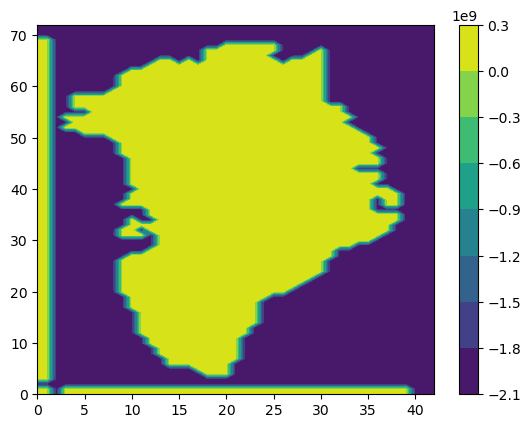

In [18]:
plt.contourf(vx_uncert_data_interp_1/vx_uncert_data_interp*(vx_uncert_data_interp>0))
plt.colorbar()

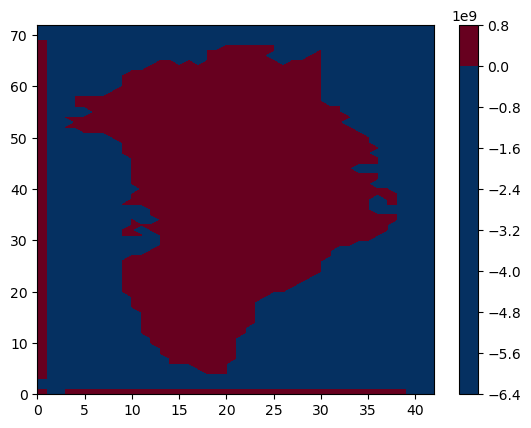

In [19]:
plt.contourf(vx_uncert_data_interp_1/ds_surfvel_data_40km["vx_uncert"].data*(ds_surfvel_data_40km["vx_uncert"].data>0), vmin = 0, vmax = 2, cmap = "RdBu_r")
plt.colorbar()

In [20]:
# OLD CELL WITH THE VARIOUS OLD UNCERTS DEFINED

# da_vs_data_orig = xr.DataArray(
#         data = vs_orig,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vs OG in ma^(-1)"),
#     )

# da_vs_data_interp = xr.DataArray(
#         data = vs_data_interp,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vs in ma^(-1)"),
#     )

# da_vx_data_interp = xr.DataArray(
#         data = vx_data_interp,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vx in ma^(-1)"),
#     )

# da_vy_data_interp = xr.DataArray(
#         data = vy_data_interp,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vy in ma^(-1)"),
#     )

# da_vx_uncert_data_interp = xr.DataArray(
#         data = vx_uncert_data_interp,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vx_uncert in ma^(-1)"),
#     )

# da_vy_uncert_data_interp = xr.DataArray(
#         data = vy_uncert_data_interp,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vy_uncert in ma^(-1)"),
#     )

# da_vx_uncert_data_interp_old = xr.DataArray(
#         data = vx_uncert_data_interp_old,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vx_uncert old way in ma^(-1)"),
#     )

# da_vy_uncert_data_interp_old = xr.DataArray(
#         data = vy_uncert_data_interp_old,
#         dims = ["y", "x"],
#         coords = dict(
#             y = yModel40,
#             x = xModel40,
#         ),  
#         attrs = dict(description="vy_uncert old way in ma^(-1)"),
#     )

# ds_surfvel_data_40km = ds_surfvel_data_40km_orig.copy()
# ds_surfvel_data_40km["vs_orig"] = da_vs_data_orig
# ds_surfvel_data_40km["vs"] = da_vs_data_interp
# ds_surfvel_data_40km["vx"] = da_vx_data_interp
# ds_surfvel_data_40km["vy"] = da_vy_data_interp

# # NEW WAY
# ds_surfvel_data_40km["vx_uncert"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert"] = da_vy_uncert_data_interp.copy()

# epsilon = 0.1
# ds_surfvel_data_40km["vx_uncert"].data = (ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
# ds_surfvel_data_40km["vy_uncert"].data = (ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# ds_surfvel_data_40km["vx_uncert_scaled"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled"] = da_vy_uncert_data_interp.copy()

# scale_uncert_factor_2 = 5.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*4.0    # Scale uncert to account for model representation error
# epsilon = 1.0
# ds_surfvel_data_40km["vx_uncert_scaled"].data = 0.2*scale_uncert_factor_2*(ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
# ds_surfvel_data_40km["vy_uncert_scaled"].data = 0.2*scale_uncert_factor_2*(ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# ds_surfvel_data_40km["vx_uncert_scaled_more"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_more"] = da_vy_uncert_data_interp.copy()

# scale_uncert_factor_2 = 100.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*95.0    # Scale uncert to account for model representation error
# epsilon = 1.0
# ds_surfvel_data_40km["vx_uncert_scaled_more"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
# ds_surfvel_data_40km["vy_uncert_scaled_more"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# ds_surfvel_data_40km["vx_uncert_scaled_most"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_most"] = da_vy_uncert_data_interp.copy()

# scale_uncert_factor_2 = 100.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*95.0    # Scale uncert to account for model representation error
# epsilon = 0.1
# ds_surfvel_data_40km["vx_uncert_scaled_most"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
# ds_surfvel_data_40km["vy_uncert_scaled_most"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# ds_surfvel_data_40km["vx_uncert_scaled_mostest"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_mostest"] = da_vy_uncert_data_interp.copy()

# scale_uncert_factor_2 = 100.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*99.0    # Scale uncert to account for model representation error
# epsilon = 0.1
# ds_surfvel_data_40km["vx_uncert_scaled_mostest"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
# ds_surfvel_data_40km["vy_uncert_scaled_mostest"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

# # OG WAYS BUT ADJUSTED TO MY NEW THINKING
# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# ds_surfvel_data_40km["vx_uncert_scaled_og"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og"] = da_vy_uncert_data_interp.copy()

# scale_uncert_factor_2 = 100.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*95.0    # Scale uncert to account for model representation error
# epsilon = 1.e-8

# ds_surfvel_data_40km["vx_uncert_scaled_og"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vx"].data**2 + epsilon)**0.5
# ds_surfvel_data_40km["vy_uncert_scaled_og"].data = 0.01*scale_uncert_factor_2*(ds_surfvel_data_40km["vy"].data**2 + epsilon)**0.5

# ds_surfvel_data_40km["vx_uncert_scaled_og_og"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_og"] = da_vy_uncert_data_interp.copy()

# ds_surfvel_data_40km["vx_uncert_scaled_og_og"].data = np.maximum(ds_surfvel_data_40km["vx_uncert_scaled_og"].data, da_vx_uncert_data_interp.data)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og"].data = np.maximum(ds_surfvel_data_40km["vy_uncert_scaled_og"].data, da_vy_uncert_data_interp.data)

# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og"] = da_vy_uncert_data_interp.copy()

# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og"].data = np.sqrt(ds_surfvel_data_40km["vx_uncert_scaled_og"].data**2 + da_vx_uncert_data_interp.data**2)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og"].data = np.sqrt(ds_surfvel_data_40km["vy_uncert_scaled_og"].data**2 + da_vy_uncert_data_interp.data**2)

# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_og"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_og"] = da_vy_uncert_data_interp.copy()

# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_og"].data = ds_surfvel_data_40km["vx_uncert_scaled_og"].data + da_vx_uncert_data_interp.data
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_og"].data = ds_surfvel_data_40km["vy_uncert_scaled_og"].data + da_vy_uncert_data_interp.data

# # OLD or OG WAY
# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# scale_uncert_factor_2 = 5.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*4.0    # Scale uncert to account for model representation error
# epsilon = 0.0

# ds_surfvel_data_40km["vx_uncert_unbounded"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vx_uncert_scaled_og_old"] = ds_surfvel_data_40km["vx_uncert_unbounded"].copy()
# ratio_x = np.abs(vx_data_interp/vx_uncert_data_interp)
# ds_surfvel_data_40km["vx_uncert_scaled_og_old"].data[ratio_x > 5.0] = 0.2*np.sqrt(vx_data_interp[ratio_x > 5.0]**2 + epsilon)
# ds_surfvel_data_40km["vx_uncert_scaled_og_old"].data = ds_surfvel_data_40km["vx_uncert_scaled_og_old"].data * scale_uncert_factor_2

# ds_surfvel_data_40km["vy_uncert_unbounded"] = da_vy_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_old"] = ds_surfvel_data_40km["vy_uncert_unbounded"].copy()
# ratio_y = np.abs(vy_data_interp/vy_uncert_data_interp)
# ds_surfvel_data_40km["vy_uncert_scaled_og_old"].data[ratio_y > 5.0] = 0.2*np.sqrt(vy_data_interp[ratio_y > 5.0]**2 + epsilon)
# ds_surfvel_data_40km["vy_uncert_scaled_og_old"].data = ds_surfvel_data_40km["vy_uncert_scaled_og_old"].data * scale_uncert_factor_2

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# scale_uncert_factor_2 = 10.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*9.0    # Scale uncert to account for model representation error
# epsilon = 0.0

# ds_surfvel_data_40km["vx_uncert_unbounded"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_old"] = ds_surfvel_data_40km["vx_uncert_unbounded"].copy() * scale_uncert_factor_2
# ratio_x = np.abs(vx_data_interp/vx_uncert_data_interp)
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_old"].data[ratio_x > 5.0] = 0.2*np.sqrt(vx_data_interp[ratio_x > 5.0]**2 + epsilon)

# ds_surfvel_data_40km["vy_uncert_unbounded"] = da_vy_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_old"] = ds_surfvel_data_40km["vy_uncert_unbounded"].copy() * scale_uncert_factor_2
# ratio_y = np.abs(vy_data_interp/vy_uncert_data_interp)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_old"].data[ratio_y > 5.0] = 0.2*np.sqrt(vy_data_interp[ratio_y > 5.0]**2 + epsilon)

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# scale_uncert_factor_2 = 5.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*4.0    # Scale uncert to account for model representation error
# epsilon = 0.0

# ds_surfvel_data_40km["vx_uncert_unbounded"] = da_vx_uncert_data_interp.copy()
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_old"] = ds_surfvel_data_40km["vx_uncert_unbounded"].copy()
# ratio_x = np.abs(vx_data_interp/vx_uncert_data_interp)
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_old"].data[ratio_x > 10.0] = 0.1*np.sqrt(vx_data_interp[ratio_x > 10.0]**2 + epsilon)
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_old"].data = ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_old"].data * scale_uncert_factor_2

# ds_surfvel_data_40km["vy_uncert_unbounded"] = da_vy_uncert_data_interp.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_old"] = ds_surfvel_data_40km["vy_uncert_unbounded"].copy()
# ratio_y = np.abs(vy_data_interp/vy_uncert_data_interp)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_old"].data[ratio_y > 10.0] = 0.1*np.sqrt(vy_data_interp[ratio_y > 10.0]**2 + epsilon)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_old"].data = ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_old"].data * scale_uncert_factor_2

# # Model representation error increases with decreasing H
# # scale_uncert_factor_1 does not exist here, it does in the age data uncert
# scale_uncert_factor_2 = 5.0 - np.abs(ds_bm5_orig["H"].data/np.max(ds_bm5_orig["H"].data))*4.0    # Scale uncert to account for model representation error
# epsilon = 0.0

# ### This will give cost as roughly 11585 or 11589, like the old one

# ds_surfvel_data_40km["vx_uncert_unbounded_old"] = da_vx_uncert_data_interp_old.copy()
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_og_old"] = ds_surfvel_data_40km["vx_uncert_unbounded_old"].copy()
# ratio_x = np.abs(vx_data_interp/vx_uncert_data_interp)
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_og_old"].data[ratio_x > 10.0] = 0.1*np.sqrt(vx_data_interp[ratio_x > 10.0]**2 + epsilon)
# ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_og_old"].data = ds_surfvel_data_40km["vx_uncert_scaled_og_og_og_og_old"].data * scale_uncert_factor_2

# ds_surfvel_data_40km["vy_uncert_unbounded_old"] = da_vy_uncert_data_interp_old.copy()
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_og_old"] = ds_surfvel_data_40km["vy_uncert_unbounded_old"].copy()
# ratio_y = np.abs(vy_data_interp/vy_uncert_data_interp)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_og_old"].data[ratio_y > 10.0] = 0.1*np.sqrt(vy_data_interp[ratio_y > 10.0]**2 + epsilon)
# ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_og_old"].data = ds_surfvel_data_40km["vy_uncert_scaled_og_og_og_og_old"].data * scale_uncert_factor_2

# !rm /scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc
# ds_surfvel_data_40km.to_netcdf(dataPath + 'surfvel_data_40kms.nc')